In [188]:
import json
import numpy as np
import numpy.typing as npt
import scipy.special as sp
from dataclasses import dataclass
from dataclasses import field
from typing import Literal
import matplotlib.pyplot as plt

# Helper Functions


In [189]:

def save_gmm(gmm, filename):
    gmmJson = [(i, j.tolist(), k.tolist()) for i, j, k in gmm]
    with open(filename, 'w') as f:
        json.dump(gmmJson, f)
    
def load_gmm(filename):
    with open(filename, 'r') as f:
        gmm = json.load(f)
    return [(i, np.asarray(j), np.asarray(k)) for i, j, k in gmm]

def vcol(vec: npt.NDArray) -> npt.NDArray:
    return vec.reshape(-1, 1)

def vrow(vec: npt.NDArray) -> npt.NDArray:
    return vec.reshape(1, -1)

def mean(x, axis=None):
    if axis is None:
        return np.sum(x, axis) / np.prod(x.shape)
    else:
        return np.sum(x, axis) / x.shape[axis]

def cov(X: npt.NDArray) -> npt.NDArray:
    """Compute the covariance matrix of the given data. Centers the data first.

    Args:
        X (npt.NDArray): The data

    Returns:
        npt.NDArray: The covariance matrix
    """
    DC = X - vcol(mean(X, 1))

    return (DC @ DC.T) / float(X.shape[1])

# Load the data


## `.npy` arrays


In [190]:
ext_data_binary_labels = np.load('data/ext_data_binary_labels.npy')
ext_data_binary = np.load('data/ext_data_binary.npy')
GMM_1D_3G_init_ll = np.load('data/GMM_1D_3G_init_ll.npy')
GMM_4D_3G_init_ll = np.load('data/GMM_4D_3G_init_ll.npy')
GMM_data_1D = np.load('data/GMM_data_1D.npy')
GMM_data_4D = np.load('data/GMM_data_4D.npy')

## `.json` GMMs


In [191]:
GMM_1D_3G_EM = load_gmm('data/GMM_1D_3G_EM.json')
GMM_1D_3G_init = load_gmm('data/GMM_1D_3G_init.json')
GMM_1D_4G_EM_LBG = load_gmm('data/GMM_1D_4G_EM_LBG.json')
GMM_4D_3G_EM = load_gmm('data/GMM_4D_3G_EM.json')
GMM_4D_3G_init = load_gmm('data/GMM_4D_3G_init.json')
GMM_4D_4G_EM_LBG = load_gmm('data/GMM_4D_4G_EM_LBG.json')

# GMM probability density function


In [192]:
def _check_params(X: npt.NDArray, mu: npt.NDArray, C: npt.NDArray) -> None:
    # fmt: off
    assert len(X.shape) == 2, f"X must be a 2D array, got {len(X.shape)}"
    assert len(mu) == X.shape[0], f"mu must have the same number of rows as X ({X.shape[0]}), got {len(mu)}"
    assert len(C.shape) == 2, f"C must be a 2D array, got {len(C.shape)}"
    assert C.shape[0] == C.shape[1], f"C must be a square matrix, got {C.shape[0]}x{C.shape[1]}"
    assert C.shape[0] == X.shape[0], f"C must have the same number of rows as X ({X.shape[0]}), got {C.shape[0]}x{C.shape[1]}"
    # fmt: on


def log_pdf_gaussian(X: npt.NDArray, mu: npt.NDArray, C: npt.NDArray) -> npt.NDArray:
    """Calculates the logarithm of the multivariate gaussian density function

    Args:
        X (NDArray): [M x N] data matrix
        mu (ArrayLike): [M x 1] mean vector
        C (NDArray): [M x M] covariance matrix

    Returns:
        NDArray: [N x 1] logarithm of the multivariate gaussian density function
    """
    X = np.atleast_2d(X)
    mu = np.atleast_1d(mu)
    C = np.atleast_2d(C)

    _check_params(X, mu, C)

    return -0.5 * (
        X.shape[0] * np.log(2 * np.pi)
        + np.linalg.slogdet(C)[1]
        + np.einsum("ij,ji->i", np.dot((X - mu).T, np.linalg.inv(C)), (X - mu))
    )

def log_pdf_gmm(
    X: npt.NDArray, gmm: list[tuple[npt.NDArray, npt.NDArray, npt.NDArray]]
):
    """Calculates the logarithm of the gaussian mixture model density function

    Args:
        X (NDArray): [M x N] data matrix
        gmm (List[Tuple[NDArray, NDArray, NDArray]]): list of tuples containing
            the weights, means and covariances of the GMM

    Returns:
        NDArray: [N x K] logarithm of the gaussian mixture model density function
    """
    S = [log_pdf_gaussian(X, mu, C) + np.log(w) for w, mu, C in gmm]

    S = np.vstack(S)

    return sp.logsumexp(S, axis=0)

In [193]:
assert np.allclose(
    log_pdf_gmm(GMM_data_4D, GMM_4D_3G_init),
    GMM_4D_3G_init_ll
)

assert np.allclose(
    log_pdf_gmm(GMM_data_1D, GMM_1D_3G_init),
    GMM_1D_3G_init_ll
)

# GMM estimation: the EM algorithm


In [194]:
@dataclass
class GaussianMixtureModel:
    X: npt.NDArray
    params: list[tuple[npt.NDArray, npt.NDArray, npt.NDArray]] = field(default_factory=list)

    def train(
        self,
        *,
        apply_lbg: bool = False,
        num_components: int = 1,
        cov_type: Literal["full"] | Literal["diagonal"] | Literal["tied"] = "full",
        eps_ll_avg: float = 1e-6,
        psi_eig: float | None = None,
    ):
        """
        Trains the Gaussian Mixture Model using the Expectation-Maximization algorithm

        Args:
            apply_lbg (bool, optional): Whether to apply the Linde-Buzo-Gray
                algorithm to initialize the GMM. Defaults to False.
            num_components (int, optional): The number of components to use in
                the GMM when applying the LBG algorithm. Defaults to 1.
            cov_type (
                Literal[full] | Literal[diagonal] | Literal[tied], optional
                ): The type of covariance matrix to use. Defaults to "full".
            psi_eig (float | None, optional): The minimum eigenvalue for the
                covariance matrix. Defaults to None.
            eps_ll_avg (float, optional): The minimum difference between the
                log-likelihoods of two consecutive iterations. Defaults to 1e-6.
        """

        if apply_lbg:
            mu = vcol(mean(self.X, axis=1))
            C = cov(self.X)

            if cov_type == "diagonal":
                C = C * np.eye(self.X.shape[0])

            self.params = [
                (
                    np.array(1.0),
                    mu,
                    C if psi_eig is None else self.smooth_covariance_matrix(C, psi_eig),
                )
            ]

            while len(self.params) < num_components:
                self.__lgb_split()
                self.__train(cov_type, eps_ll_avg, psi_eig)
        else:
            self.__train(cov_type, eps_ll_avg, psi_eig)

    def __train(self, cov_type, eps_ll_avg, psi_eig):
        """
        Trains the Gaussian Mixture Model using the Expectation-Maximization algorithm
        """

        while True:
            old_ll = mean(log_pdf_gmm(self.X, self.params))
            self.__em_it(cov_type, psi_eig)
            new_ll = mean(log_pdf_gmm(self.X, self.params))

            if new_ll - old_ll < eps_ll_avg:
                break

    def __em_it(self, cov_type, psi_eig):
        """
        Applies one iteration of the Expectation-Maximization algorithm
        """

        # E-step
        S = [log_pdf_gaussian(self.X, mu, C) + np.log(w) for w, mu, C in self.params]

        S = np.vstack(S)

        log_densities = sp.logsumexp(S, axis=0)

        # Posterior probabilities for all clusters, each row corresponds to a
        # Gaussian component, each column corresponds to a sample
        responsibilities = np.exp(S - log_densities)

        # M-step
        new_params = []
        for resp in responsibilities:
            Z = resp.sum()
            F = vcol((vrow(resp) * self.X).sum(1))
            S = (vrow(resp) * self.X) @ self.X.T

            # Update the parameters
            mu = F / Z
            C = S / Z - mu @ mu.T
            w = Z / self.X.shape[1]

            if cov_type.lower() == "diagonal":
                C = C * np.eye(self.X.shape[0])

            new_params.append((w, mu, C))

        if cov_type.lower() == "tied":
            C_tied = sum(w * C for w, _, C in new_params)

            for i, (w, mu, _) in enumerate(new_params):
                new_params[i] = (w, mu, C_tied)

        if psi_eig is not None:
            for i, (w, mu, C) in enumerate(new_params):
                new_params[i] = (w, mu, self.smooth_covariance_matrix(C, psi_eig))

        self.params = new_params

    def __lgb_split(self, alpha=0.1):
        """
        Splits the components of the GMM using the Linde-Buzo-Gray algorithm

        Args:
            alpha (float, optional): The scaling factor for the displacement.
                Defaults to 0.1.
        """

        new_params = []
        for w, mu, C in self.params:
            U, s, _ = np.linalg.svd(C)
            displacement = U[:, :1] * s[0] ** 0.5 * alpha
            new_params.append((0.5 * w, mu - displacement, C))
            new_params.append((0.5 * w, mu + displacement, C))

        self.params = new_params

    @staticmethod
    def smooth_covariance_matrix(C: npt.NDArray, psi: float):
        """
        Smoothes the covariance matrix by setting the eigenvalues below a
        certain threshold to that threshold value

        Args:
            C (npt.NDArray): The covariance matrix
            psi (float): The minimum eigenvalue

        Returns:
            npt.NDArray: The smoothed covariance matrix
        """

        U, s, _ = np.linalg.svd(C)
        s[s < psi] = psi
        return U @ (vcol(s) * U.T)


In [195]:
gmm = GaussianMixtureModel(GMM_data_4D, GMM_4D_3G_init)

gmm.train()

assert np.allclose(
    log_pdf_gmm(GMM_data_4D, gmm.params).mean(),
    -7.26325603
)

## Plot the 1D GMM


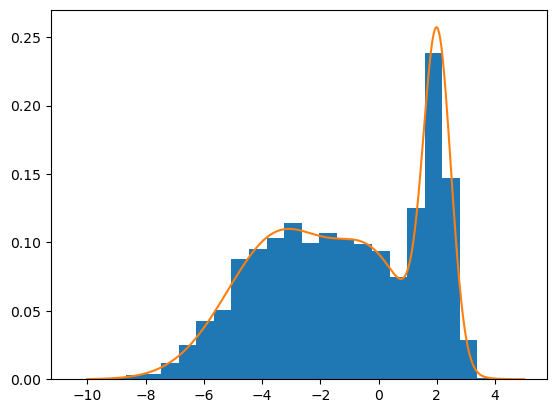

In [196]:
gmm = GaussianMixtureModel(GMM_data_1D, GMM_1D_3G_init)

gmm.train()

plt.figure()
plt.hist(GMM_data_1D.ravel(), 25, density=True)
xs = np.linspace(-10, 5, 1000)

plt.plot(xs.ravel(), np.exp(log_pdf_gmm(vrow(xs), gmm.params)))

plt.show()

# LGB Algorithm


In [197]:
gmm = GaussianMixtureModel(GMM_data_4D)

gmm.train(apply_lbg=True, num_components=4)

assert np.allclose(
    log_pdf_gmm(GMM_data_4D, gmm.params).mean(),
    -7.25337844
)

## Plot the 1D GMM


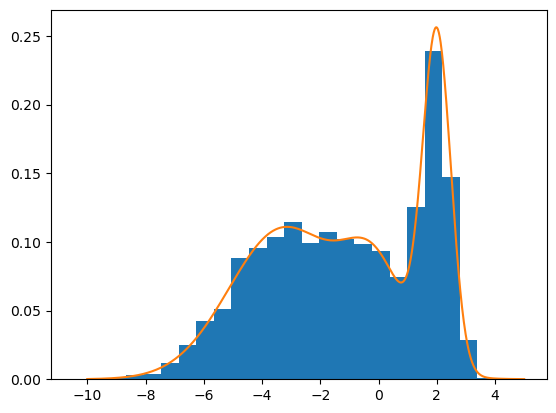

In [198]:
gmm = GaussianMixtureModel(GMM_data_1D)

gmm.train(apply_lbg=True, num_components=4)

plt.figure()
plt.hist(GMM_data_1D.ravel(), 25, density=True)
xs = np.linspace(-10, 5, 1000)

plt.plot(xs.ravel(), np.exp(log_pdf_gmm(vrow(xs), gmm.params)))

plt.show()